# Phase 1 — Data Consolidation and Label Engineering

This notebook loads CIC-IoT-2023 dataset CSV files, consolidates them, handles missing values, performs label encoding, and saves the consolidated dataset.

**Dataset:** CIC-IoT-2023 (IoT Network Intrusion Detection)
- **Files:** 169 CSV files (or use pre-merged single file)
- **Features:** 46 network flow features
- **Label:** Binary or multi-class attack classification
- **Size:** ~13 GB uncompressed

**Note:** This notebook supports both CICIDS2017 and CIC-IoT-2023 datasets.

In [1]:
from pathlib import Path
import glob
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
import gc

print("Successfully loaded libraries")

Successfully loaded libraries


In [2]:
# ===================================================================
# CONFIGURATION: Choose your dataset
# ===================================================================
DATASET = "CICIoT2023"  # Options: "CICIDS2017" or "CICIoT2023"

if DATASET == "CICIoT2023":
    DATA_DIR = Path("../data/raw/CICIoT2023/CSV")  # CIC-IoT-2023 CSV directory
    OUT_DIR = Path("../data/processed/CICIoT2023")
    LABEL_COL = "label"  # CIC-IoT-2023 uses lowercase 'label'
else:
    print("Check the directory if it exists")
    #DATA_DIR = Path("../data/raw/CICIDS2017")  # CICIDS2017
    #OUT_DIR = Path("../data/processed/CICIDS2017")
    #LABEL_COL = "Label"  # CICIDS2017 uses uppercase 'Label'

OUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Selected Dataset: {DATASET}")
print(f"Data Directory: {DATA_DIR}")
print(f"Output Directory: {OUT_DIR}")

Selected Dataset: CICIoT2023
Data Directory: ..\data\raw\CICIoT2023\CSV
Output Directory: ..\data\processed\CICIoT2023


In [3]:
# ===================================================================
# Memory Optimization Utilities
# ===================================================================

def get_memory_usage():
    """Get current memory usage in GB"""
    process = psutil.Process()
    return process.memory_info().rss / 1024**3

def optimize_dtypes(df):
    """Reduce memory usage by optimizing data types"""
    print("\nOptimizing data types...")
    start_mem = df.memory_usage(deep=True).sum() / 1024**3
    print(f"  Initial memory: {start_mem:.2f} GB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    
    end_mem = df.memory_usage(deep=True).sum() / 1024**3
    saved = start_mem - end_mem
    print(f"  Final memory: {end_mem:.2f} GB")
    print(f"  Saved: {saved:.2f} GB ({100 * saved / start_mem:.1f}%)")
    
    return df

print(f"System RAM: {psutil.virtual_memory().total / 1024**3:.1f} GB")
print(f"Available RAM: {psutil.virtual_memory().available / 1024**3:.1f} GB")
print(f"Current process memory: {get_memory_usage():.2f} GB")

System RAM: 15.7 GB
Available RAM: 4.8 GB
Current process memory: 0.20 GB


In [4]:
# ===================================================================
# STEP 1: Load CSV files (MEMORY-OPTIMIZED)
# ===================================================================
files = sorted(glob.glob(str(DATA_DIR / "*.csv")))
print(f"Found {len(files)} CSV files")

if len(files) == 0:
    print("ERROR: No CSV files found!")
    print(f"Please download the dataset and place CSV files in: {DATA_DIR}")
    print(f"For CIC-IoT-2023, download from:")
    print(f"http://cicresearch.ca/IOTDataset/CIC_IOT_Dataset2023/CSV/")
    raise FileNotFoundError(f"No CSV files in {DATA_DIR}")

# Load files with progress indicator and memory optimization
print("Loading files with memory optimization...")
print(f"Process memory before loading: {get_memory_usage():.2f} GB")

dfs = []
for i, f in enumerate(files):
    print(f"  [{i+1}/{len(files)}] Loading {Path(f).name}...", end='')
    try:
        # First, read just the header to identify columns
        sample = pd.read_csv(f, nrows=1)
        sample.columns = sample.columns.str.strip()
        
        # Identify label column (typically string/object type)
        label_cols = [col for col in sample.columns 
                     if col.lower() in ['label', 'attack', 'class', 'label_id']]
        
        # Create dtype specification: float32 for all except label columns
        dtypes = {col: np.float32 for col in sample.columns if col not in label_cols}
        
        # Load with optimized dtypes
        df = pd.read_csv(f, dtype=dtypes, low_memory=False)
        df.columns = df.columns.str.strip()  # Clean column names
        
        dfs.append(df)
        
        # Periodic garbage collection to free memory
        if (i + 1) % 20 == 0:
            gc.collect()
            
    except Exception as e:
        print(f"Warning: Could not load {f}: {e}")
        continue

print(f"Successfully loaded {len(dfs)} files")
print(f"Process memory after loading: {get_memory_usage():.2f} GB")

Found 169 CSV files
Loading files with memory optimization...
Process memory before loading: 0.20 GB
  [1/169] Loading part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv...  [2/169] Loading part-00001-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv...  [3/169] Loading part-00002-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv...  [4/169] Loading part-00003-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv...  [5/169] Loading part-00004-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv...  [6/169] Loading part-00005-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv...  [7/169] Loading part-00006-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv...  [8/169] Loading part-00007-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv...  [9/169] Loading part-00008-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv...  [10/169] Loading part-00009-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv...  [11/169] Loading part-00010-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv...  [12/169] Loading part-00011-363d1ba3-8ab5-4f96-b

In [5]:
# ===================================================================
# STEP 2: Concatenate all dataframes (MEMORY-OPTIMIZED)
# ===================================================================
print("\nCombining datasets...")
print(f"Process memory before concat: {get_memory_usage():.2f} GB")

df = pd.concat(dfs, ignore_index=True)

# Clear the list to free memory
del dfs
gc.collect()

print(f"Combined shape: {df.shape}")
print(f"  Rows: {df.shape[0]:,}")
print(f"  Columns: {df.shape[1]}")
print(f"Process memory after concat: {get_memory_usage():.2f} GB")

# Display sample
print("\nFirst few rows:")
display(df.head())

# Memory usage summary
print(f"\nDataFrame memory usage: {df.memory_usage(deep=True).sum() / 1024**3:.2f} GB")


Combining datasets...
Process memory before concat: 7.34 GB
Combined shape: (46686579, 47)
  Rows: 46,686,579
  Columns: 47
Process memory after concat: 5.38 GB

First few rows:


,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.000000,54.000000,6.00,64.000000,0.329807,0.329807,0.0,1.0,0.0,1.0,...,0.000000,54.000000,83343832.0,9.5,10.392304,0.000000,0.000000,0.00,141.550003,DDoS-RSTFINFlood
1,0.000000,57.040001,6.33,64.000000,4.290556,4.290556,0.0,0.0,0.0,0.0,...,2.822973,57.040001,82926064.0,9.5,10.464666,4.010353,160.987839,0.05,141.550003,DoS-TCP_Flood
2,0.000000,0.000000,1.00,64.000000,33.396801,33.396801,0.0,0.0,0.0,0.0,...,0.000000,42.000000,83127992.0,9.5,9.165152,0.000000,0.000000,0.00,141.550003,DDoS-ICMP_Flood
3,0.328175,76175.000000,17.00,64.000000,4642.132812,4642.132812,0.0,0.0,0.0,0.0,...,0.000000,50.000000,83015696.0,9.5,10.000000,0.000000,0.000000,0.00,141.550003,DoS-UDP_Flood
4,0.117320,101.730003,6.11,65.910004,6.202211,6.202211,0.0,0.0,1.0,0.0,...,23.113111,57.880001,82973000.0,9.5,11.346876,32.716244,3016.808350,0.19,141.550003,DoS-SYN_Flood



DataFrame memory usage: 11.15 GB


In [6]:
# ===================================================================
# STEP 3: Inspect missing values
# ===================================================================
print("\n" + "=" * 60)
print("Missing Values Analysis")
print("=" * 60)
missing = df.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if len(missing) > 0:
    print(f"\nColumns with missing values ({len(missing)} columns):")
    print(missing.head(20))  # Show top 20
    print(f"\nTotal missing values: {missing.sum():,}")
else:
    print("\n✓ No missing values found!")


Missing Values Analysis

✓ No missing values found!


In [7]:
# ===================================================================
# STEP 4: Handle infinite values and missing data (MEMORY-EFFICIENT)
# ===================================================================
print("" + "=" * 60)
print("Data Cleaning (Memory-Efficient Processing)")
print("=" * 60)

before = df.shape[0]

# Replace inf with NaN
print("Replacing infinite values...")
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check for infinite values
inf_count = df.isna().sum().sum() - missing.sum()
if inf_count > 0:
    print(f"Replaced {inf_count:,} infinite values with NaN")

print(f"Memory usage before cleaning: {df.memory_usage(deep=True).sum() / 1024**3:.2f} GB")

Data Cleaning (Memory-Efficient Processing)
Replacing infinite values...
Memory usage before cleaning: 11.15 GB


In [8]:
# ===================================================================
# MEMORY-EFFICIENT: Drop rows with NaN without copying
# ===================================================================
print("Dropping rows with missing values...")

# Get boolean mask of rows to keep (avoids copy)
mask = df.notna().all(axis=1)
rows_to_keep = mask.sum()
dropped = before - rows_to_keep

print(f"  Rows to drop: {dropped:,} ({(dropped/before)*100:.2f}%)")
print(f"  Rows to keep: {rows_to_keep:,}")

# If there are rows to drop, filter in place
if dropped > 0:
    # Use boolean indexing to filter - creates one copy of filtered data
    df = df[mask].copy()
    print(f"Successfully filtered dataset")
else:
    print("No rows to drop")

after = df.shape[0]
print(f"Final dataset size: {after:,} rows")
print(f"Memory usage after cleaning: {df.memory_usage(deep=True).sum() / 1024**3:.2f} GB")

Dropping rows with missing values...
  Rows to drop: 0 (0.00%)
  Rows to keep: 46,686,579
No rows to drop
Final dataset size: 46,686,579 rows
Memory usage after cleaning: 11.15 GB


In [9]:
# ===================================================================
# STEP 5: Drop non-informative columns
# ===================================================================
print("\n" + "=" * 60)
print("Dropping Non-Informative Columns")
print("=" * 60)

# Common identifiers to drop
drop_cols = [c for c in [
    'Flow ID', 'flow_id', 'Src IP', 'src_ip', 'Dst IP', 'dst_ip',
    'Source IP', 'Destination IP', 'Timestamp', 'timestamp',
    'Src Port', 'src_port', 'Dst Port', 'dst_port',
    'Unnamed: 0', 'flow_id'
] if c in df.columns]

if drop_cols:
    print(f"Dropping columns: {drop_cols}")
    df.drop(columns=drop_cols, inplace=True, errors='ignore')
else:
    print("No identifier columns to drop")

# Clean column names
df.columns = df.columns.str.strip()


Dropping Non-Informative Columns
No identifier columns to drop


In [10]:
# ===================================================================
# STEP 6: Label encoding
# ===================================================================
print("\n" + "=" * 60)
print("Label Encoding")
print("=" * 60)

if LABEL_COL not in df.columns:
    # Try to find label column with different cases
    label_candidates = [c for c in df.columns if c.lower() in ['label', 'attack', 'class']]
    if label_candidates:
        LABEL_COL = label_candidates[0]
        print(f"Found label column: {LABEL_COL}")
    else:
        raise KeyError(f"No label column found. Available columns: {list(df.columns)}")

# Check label distribution before encoding
print(f"\nOriginal label distribution:")
label_counts = df[LABEL_COL].value_counts()
print(label_counts)

# Create label encoder
encoder = LabelEncoder()
df['Label_ID'] = encoder.fit_transform(df[LABEL_COL])

print(f"\nLabel mapping:")
mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
for label, encoded_id in sorted(mapping.items(), key=lambda x: x[1]):
    count = (df['Label_ID'] == encoded_id).sum()
    print(f"  {encoded_id}: {label:30s} ({count:,} samples)")

print(f"\nTotal unique labels: {len(encoder.classes_)}")


Label Encoding

Original label distribution:
label
DDoS-ICMP_Flood            7200504
DDoS-UDP_Flood             5412287
DDoS-TCP_Flood             4497667
DDoS-PSHACK_Flood          4094755
DDoS-SYN_Flood             4059190
DDoS-RSTFINFlood           4045285
DDoS-SynonymousIP_Flood    3598138
DoS-UDP_Flood              3318595
DoS-TCP_Flood              2671445
DoS-SYN_Flood              2028834
BenignTraffic              1098195
Mirai-greeth_flood          991866
Mirai-udpplain              890576
Mirai-greip_flood           751682
DDoS-ICMP_Fragmentation     452489
MITM-ArpSpoofing            307593
DDoS-UDP_Fragmentation      286925
DDoS-ACK_Fragmentation      285104
DNS_Spoofing                178911
Recon-HostDiscovery         134378
Recon-OSScan                 98259
Recon-PortScan               82284
DoS-HTTP_Flood               71864
VulnerabilityScan            37382
DDoS-HTTP_Flood              28790
DDoS-SlowLoris               23426
DictionaryBruteForce         13064
Bro

In [11]:
# ===================================================================
# STEP 7: Save consolidated dataset and encoder
# ===================================================================
print("\n" + "=" * 60)
print("Saving Processed Data")
print("=" * 60)

combined_path = OUT_DIR / "combined.csv"
encoder_path = Path('../trained_models/encoder.pkl')
encoder_path.parent.mkdir(parents=True, exist_ok=True)

# Save dataset
print(f"Saving dataset to: {combined_path}")
df.to_csv(combined_path, index=False)
print(f"  File size: {combined_path.stat().st_size / (1024**2):.2f} MB")

# Save encoder
joblib.dump(encoder, encoder_path)
print(f"Saved label encoder to: {encoder_path}")

print(f"\nData consolidation complete!")
print(f"Total samples: {df.shape[0]:,}")
print(f"Total features: {df.shape[1] - 2}")  # Exclude Label and Label_ID



Saving Processed Data
Saving dataset to: ..\data\processed\CICIoT2023\combined.csv
  File size: 11343.40 MB
Saved label encoder to: ..\trained_models\encoder.pkl

Data consolidation complete!
Total samples: 46,686,579
Total features: 46



Label Distribution Visualization


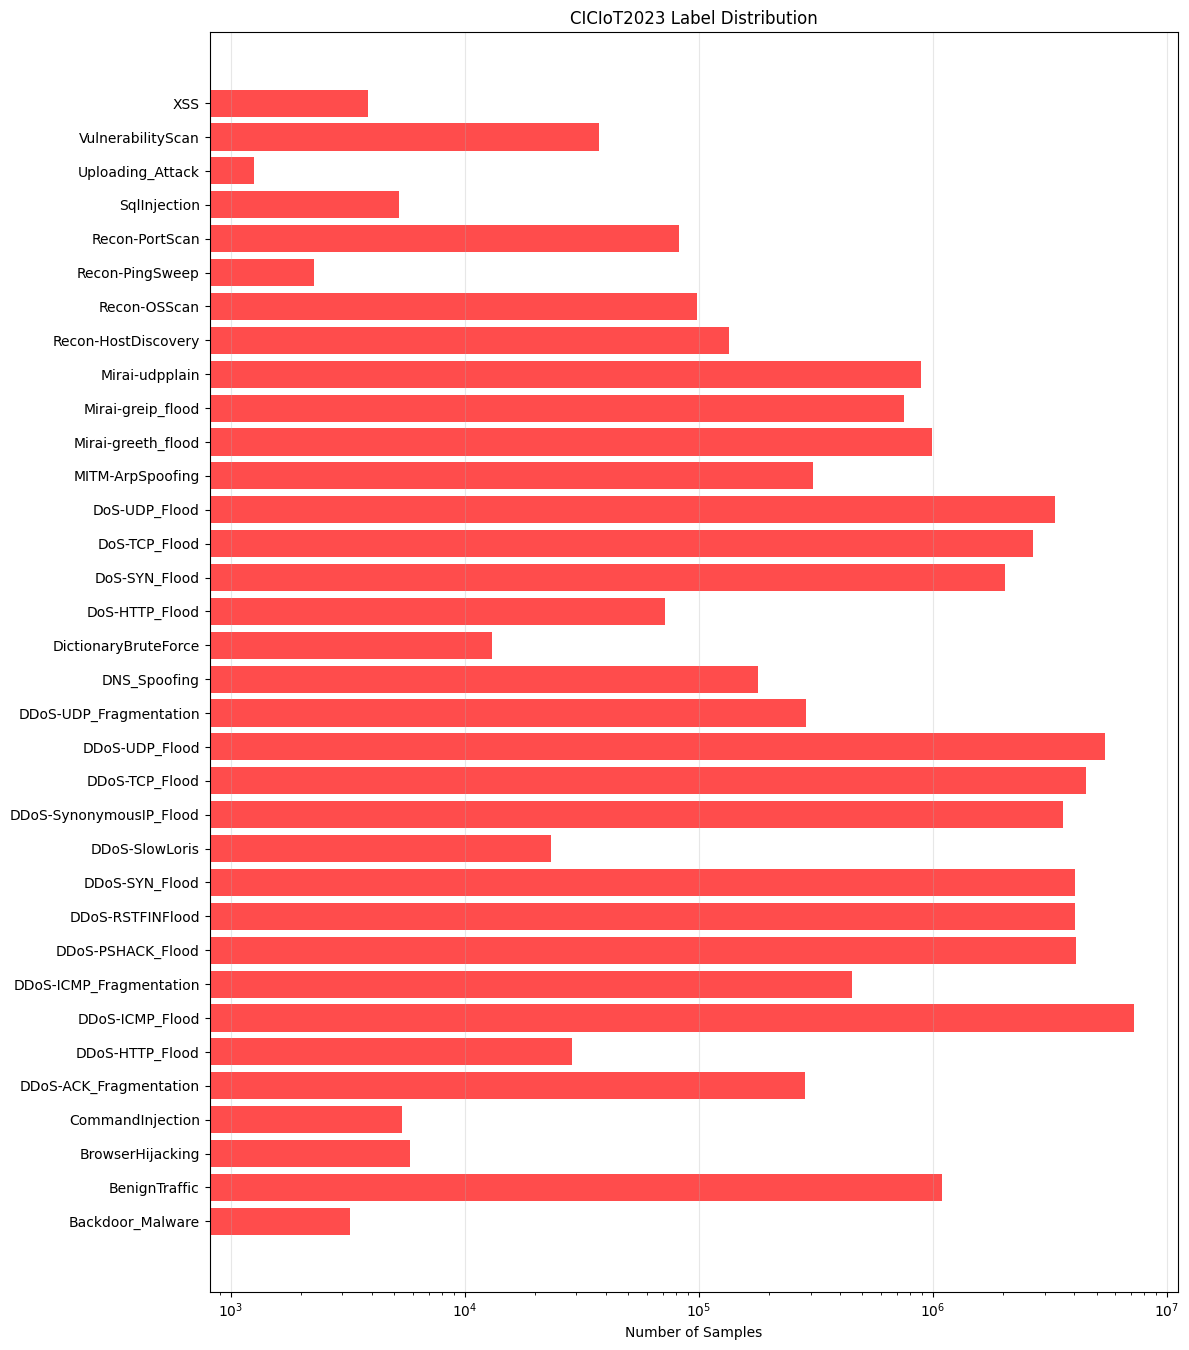

Saved visualization to: ..\data\processed\CICIoT2023\label_distribution.png


In [12]:
# ===================================================================
# STEP 8: Visualize label distribution
# ===================================================================
print("\n" + "=" * 60)
print("Label Distribution Visualization")
print("=" * 60)

plt.figure(figsize=(12, max(6, len(encoder.classes_) * 0.4)))
label_counts = df['Label_ID'].value_counts().sort_index()

# Create bar plot
ax = plt.subplot(1, 1, 1)
colors = ['green' if encoder.classes_[i].lower() in ['benign', 'normal'] else 'red' 
          for i in label_counts.index]
ax.barh(range(len(label_counts)), label_counts.values, color=colors, alpha=0.7)
ax.set_yticks(range(len(label_counts)))
ax.set_yticklabels([encoder.classes_[i] for i in label_counts.index])
ax.set_xlabel('Number of Samples')
ax.set_title(f'{DATASET} Label Distribution')
ax.set_xscale('log')  # Log scale for better visualization
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(OUT_DIR / 'label_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved visualization to: {OUT_DIR / 'label_distribution.png'}")